In [96]:
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress CUDA errors
import tensorflow as tf
from keras import mixed_precision, utils, saving, layers, losses, optimizers, metrics, callbacks, Sequential
from sklearn import model_selection

mixed_precision.set_global_policy('mixed_float16') # https://keras.io/2/api/mixed_precision/policy/
utils.set_random_seed(42)

In [97]:
test_inputs = pl.read_csv('test.csv').drop(['date_id', 'is_scored'])
test_inputs

D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,0,0,1,0,0,1,0,1.577651,0.186177,0.001323,0.001323,0.001323,0.001323,0.955026,-0.583419,-0.704264,0.298365,-0.691361,1.259065,1.556516,1.71258,0.033069,0.333333,0.036376,-0.046483,-0.312326,0.913029,0.306217,1.025756,0.081349,0.478175,0.675627,0.699735,0.256283,0.36045,…,0.794643,-1.427834,0.352513,0.926257,0.431383,-0.476976,0.500245,1.784173,0.029762,0.294719,0.51455,0.446429,0.466551,0.085717,-0.230132,0.272487,-0.106894,0.199735,0.409392,0.532717,0.744048,0.440476,-0.654839,0.699735,0.699074,-0.5024,0.882937,0.892196,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,0.003541,0.000161,0.003068
0,0,0,0,1,0,0,1,0,1.575182,0.185847,0.000992,0.000992,0.000992,0.000992,0.955357,-0.583074,-0.703759,0.297608,-0.504499,1.193468,1.554184,1.640054,0.032738,0.333003,0.036045,0.073582,-0.312345,0.91336,0.305886,0.989571,0.082672,0.477844,0.661527,0.719577,0.255952,0.361111,…,0.71131,-1.37652,0.953042,0.386905,0.523549,-0.421365,-0.234829,1.770175,0.03373,0.304496,0.638228,0.636905,1.849101,0.28169,-0.041995,0.448413,0.094321,0.215608,0.409392,0.597864,0.872354,0.691138,-0.583443,0.62996,0.598545,-0.394268,0.863757,0.699074,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,-0.005964,0.000162,-0.006437
0,0,0,0,1,0,0,0,1,1.57272,0.185516,0.000661,0.000661,0.000661,0.000661,0.955688,-0.083356,-0.573546,0.225822,-0.393903,1.123361,1.551723,1.562722,0.032407,0.332672,0.035714,0.033581,-0.312364,0.91369,0.291997,1.040514,0.081349,0.477513,0.655741,0.724206,0.22619,0.35582,…,0.212632,-1.34762,0.210979,0.635251,-1.138198,-0.494248,-1.042718,1.754171,0.032407,0.257609,0.082011,0.152116,-0.201611,0.346373,0.054032,0.137566,0.294305,0.194444,0.409392,0.596528,0.778439,0.634921,-0.483236,0.669974,0.603836,-0.17042,0.848545,0.647487,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,-0.00741,0.00016,-0.007882
0,0,0,0,1,0,0,0,1,1.570266,0.185185,0.019841,0.019841,0.006614,0.006614,0.956019,-0.083403,-0.57318,0.225094,-0.541646,1.167982,1.549272,1.611215,0.032077,0.332341,0.035384,0.033998,-0.312383,0.914021,0.267196,1.091376,0.085979,0.477183,0.648582,0.728175,0.230159,0.351852,…,0.660714,-1.399411,0.724868,0.21627,-0.230557,-0.318347,0.396917,1.769678,0.03373,0.20235,0.324074,0.212963,0.052878,-0.049023,0.120828,0.219577,0.137942,0.167328,0.409392,0.579726,0.449735,0.665344,-0.546298,0.590608,0.558862,-0.275099,0.826058,0.445767,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,0.00542,0.00016,0.004949
0,0,0,0,0,0,1,0,1,1.567818,0.184854,0.019511,0.019511,0.006283,0.006283,0.956349,-0.083449,-0.572813,0.224366,-0.714549,1.243713,1.542543,1.693604,0.031746,0.332011,0.035053,0.029586,-0.301855,0.914352,0.260913,1.011571,0.093915,0.476852,0.638667,0.729497,0.238757,0.353836,…,0.32672,-1.416282,0.611442,0.426257,0.046472,-0.262086,1.304142,1.785515,0.039683,0.230364,0.583995,0.445106,1.378927,-0.182025,0.01261,0.369048,0.011021,0.130291,0.409392,0.572656,0.489418,0.600529,-0.587258,0.46131,0.487434,-0.39548,0.80754,0.707672,0.839947,0.944593,0.715608,-0.692649,0.124669,-0.654045,0.008357,0.000159,0.007887
0,0,0,0,0,0,0,0,0,1.565379,0.184524,0.01918,0.01918,0.005952,0.005952,0.911376,-0.083496,-0.572447,0.223638,-0.122314,1.20925,1.540116,1.655174,0.031415,0.33168,0.034722,0.038269,-0.301876,0.914683,0.27414,0.984115,0.080688,0.476521,0.597442,0.718254,0.238757,0.351852,…,0.625331,-1.354498,0.046296,0.51455,0.276769,-0.261326,

In [98]:
test_solution = test_inputs.with_columns(
    forward_returns=pl.col('lagged_forward_returns').shift(1),
    risk_free_rate=pl.col('lagged_risk_free_rate').shift(1),
    market_forward_excess_returns=pl.col('lagged_market_forward_excess_returns').shift(1),
).drop(['lagged_forward_returns','lagged_risk_free_rate','lagged_market_forward_excess_returns']).fill_null(0)
test_solution

D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,0,0,1,0,0,1,0,1.577651,0.186177,0.001323,0.001323,0.001323,0.001323,0.955026,-0.583419,-0.704264,0.298365,-0.691361,1.259065,1.556516,1.71258,0.033069,0.333333,0.036376,-0.046483,-0.312326,0.913029,0.306217,1.025756,0.081349,0.478175,0.675627,0.699735,0.256283,0.36045,…,0.794643,-1.427834,0.352513,0.926257,0.431383,-0.476976,0.500245,1.784173,0.029762,0.294719,0.51455,0.446429,0.466551,0.085717,-0.230132,0.272487,-0.106894,0.199735,0.409392,0.532717,0.744048,0.440476,-0.654839,0.699735,0.699074,-0.5024,0.882937,0.892196,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,0.0,0.0,0.0
0,0,0,0,1,0,0,1,0,1.575182,0.185847,0.000992,0.000992,0.000992,0.000992,0.955357,-0.583074,-0.703759,0.297608,-0.504499,1.193468,1.554184,1.640054,0.032738,0.333003,0.036045,0.073582,-0.312345,0.91336,0.305886,0.989571,0.082672,0.477844,0.661527,0.719577,0.255952,0.361111,…,0.71131,-1.37652,0.953042,0.386905,0.523549,-0.421365,-0.234829,1.770175,0.03373,0.304496,0.638228,0.636905,1.849101,0.28169,-0.041995,0.448413,0.094321,0.215608,0.409392,0.597864,0.872354,0.691138,-0.583443,0.62996,0.598545,-0.394268,0.863757,0.699074,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,0.003541,0.000161,0.003068
0,0,0,0,1,0,0,0,1,1.57272,0.185516,0.000661,0.000661,0.000661,0.000661,0.955688,-0.083356,-0.573546,0.225822,-0.393903,1.123361,1.551723,1.562722,0.032407,0.332672,0.035714,0.033581,-0.312364,0.91369,0.291997,1.040514,0.081349,0.477513,0.655741,0.724206,0.22619,0.35582,…,0.212632,-1.34762,0.210979,0.635251,-1.138198,-0.494248,-1.042718,1.754171,0.032407,0.257609,0.082011,0.152116,-0.201611,0.346373,0.054032,0.137566,0.294305,0.194444,0.409392,0.596528,0.778439,0.634921,-0.483236,0.669974,0.603836,-0.17042,0.848545,0.647487,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,-0.005964,0.000162,-0.006437
0,0,0,0,1,0,0,0,1,1.570266,0.185185,0.019841,0.019841,0.006614,0.006614,0.956019,-0.083403,-0.57318,0.225094,-0.541646,1.167982,1.549272,1.611215,0.032077,0.332341,0.035384,0.033998,-0.312383,0.914021,0.267196,1.091376,0.085979,0.477183,0.648582,0.728175,0.230159,0.351852,…,0.660714,-1.399411,0.724868,0.21627,-0.230557,-0.318347,0.396917,1.769678,0.03373,0.20235,0.324074,0.212963,0.052878,-0.049023,0.120828,0.219577,0.137942,0.167328,0.409392,0.579726,0.449735,0.665344,-0.546298,0.590608,0.558862,-0.275099,0.826058,0.445767,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,-0.00741,0.00016,-0.007882
0,0,0,0,0,0,1,0,1,1.567818,0.184854,0.019511,0.019511,0.006283,0.006283,0.956349,-0.083449,-0.572813,0.224366,-0.714549,1.243713,1.542543,1.693604,0.031746,0.332011,0.035053,0.029586,-0.301855,0.914352,0.260913,1.011571,0.093915,0.476852,0.638667,0.729497,0.238757,0.353836,…,0.32672,-1.416282,0.611442,0.426257,0.046472,-0.262086,1.304142,1.785515,0.039683,0.230364,0.583995,0.445106,1.378927,-0.182025,0.01261,0.369048,0.011021,0.130291,0.409392,0.572656,0.489418,0.600529,-0.587258,0.46131,0.487434,-0.39548,0.80754,0.707672,0.839947,0.944593,0.715608,-0.692649,0.124669,-0.654045,0.00542,0.00016,0.004949
0,0,0,0,0,0,0,0,0,1.565379,0.184524,0.01918,0.01918,0.005952,0.005952,0.911376,-0.083496,-0.572447,0.223638,-0.122314,1.20925,1.540116,1.655174,0.031415,0.33168,0.034722,0.038269,-0.301876,0.914683,0.27414,0.984115,0.080688,0.476521,0.597442,0.718254,0.238757,0.351852,…,0.625331,-1.354498,0.046296,0.51455,0.276769,-0.261326,0.811754,1.784929,0.039683,0.249933,

In [99]:
model_names = ['v55']
models = []
for name in model_names: models.append(saving.load_model(f'.models/{name}.keras', compile=False))
signals = models[0].predict(test_inputs) #+ models[1].predict(test_inputs)
signals

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


array([[2.830e-01],
       [7.515e-01],
       [9.971e-01],
       [1.031e-04],
       [1.000e+00],
       [8.647e-01],
       [1.001e-02],
       [9.980e-01],
       [1.210e-02],
       [1.456e-02]], dtype=float16)

In [100]:
test_submission = pl.DataFrame(signals, schema=['prediction'])
test_submission

prediction
f32
0.282959
0.751465
0.99707
0.000103
1.0
0.864746
0.01001
0.998047
0.0121


In [101]:
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

def score(solution: pl.DataFrame, submission: pl.DataFrame) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

    if not submission['prediction'].dtype.is_numeric(): raise Exception('Predictions must be numeric')

    solution = solution.with_columns(position=submission['prediction'])

    pos_max = solution.select(pl.col('position').max()).item()
    if pos_max > MAX_INVESTMENT: raise Exception(f'Position of {pos_max} exceeds maximum of {MAX_INVESTMENT}')

    pos_min = solution.select(pl.col('position').min()).item()
    if pos_min < MIN_INVESTMENT: raise Exception(f'Position of {pos_min} below minimum of {MIN_INVESTMENT}')

    solution = solution.with_columns(strategy_returns=pl.col('risk_free_rate') * (1 - pl.col('position')) + pl.col('position') * pl.col('forward_returns'))

    n = len(solution)
    trading_days_per_yr = 252

    # Calculate strategy's Sharpe ratio
    strategy_excess_cumulative = solution.select((1 + (pl.col('strategy_returns') - pl.col('risk_free_rate'))).product()).item()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / n) - 1
    strategy_std = solution.select(pl.col('strategy_returns').std()).item()
    if strategy_std == 0: raise Exception('Division by zero, strategy std is zero')
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_cumulative = solution.select((1 + (pl.col('forward_returns') - pl.col('risk_free_rate'))).product()).item()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / n) - 1
    market_std = solution.select(pl.col('forward_returns').std()).item()
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)
    if market_volatility == 0: raise Exception('Division by zero, market std is zero')

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

In [102]:
score(test_solution, test_submission)

4.910602871266575

it overshoots a bit, but still good enough approximation to score new models outside of official submissions

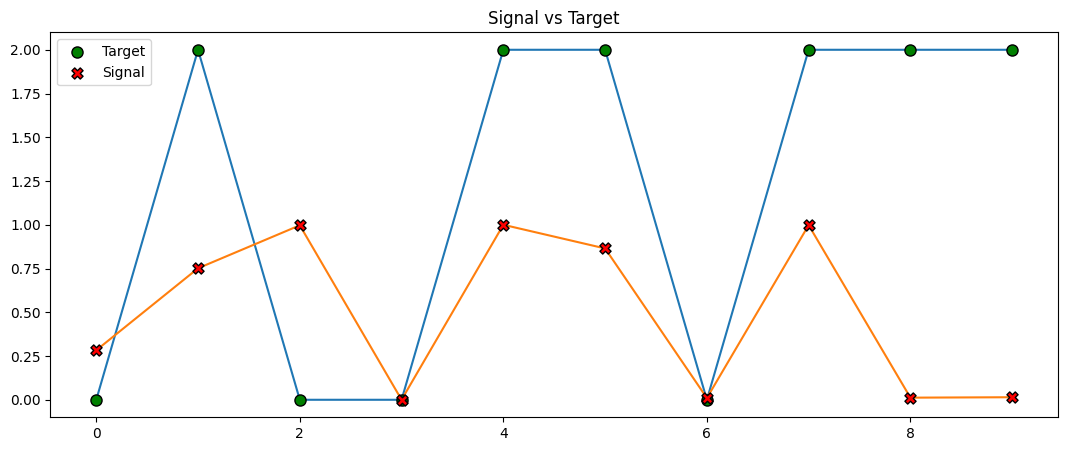

In [103]:
test_targets = np.where(test_solution['market_forward_excess_returns'] > 0, MAX_INVESTMENT, MIN_INVESTMENT)
plt.figure(figsize=(13, 5))
plt.title(f'Signal vs Target')
plt.plot(test_targets, zorder=-1)
indices = np.arange(test_targets.shape[0])
plt.scatter(indices, test_targets, label='Target', edgecolors='k', c='g', s=64)
plt.plot(signals, zorder=-1)
plt.scatter(indices, signals, label='Signal', marker='X', edgecolors='k', c='r', s=64)
plt.legend()
pass